# Review Text Analysis

### Data Cleaning

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import sqlite3
from pyspark import SparkContext
sc =SparkContext()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import collections
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dependencies
import re, string

import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/janelchadiarova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/janelchadiarova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/janelchadiarova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Create connections to database
conn = sqlite3.connect("Data/Hotels.db")

#Load the database table into a pandas dataframe
ratings = pd.read_sql_query("select * from ratings;", conn)
conn.close()

# Preview the dataframe
ratings.head()

,index,name,reviews_date,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,reviews_userCity,reviews_userProvince
0,0,Rancho Valencia Resort Spa,2013-11-14T00:00:00Z,5.0,www.hotels.com,Our experience at Rancho Valencia was absolute...,Best romantic vacation ever!!!!,None,None
1,1,Rancho Valencia Resort Spa,2014-07-06T00:00:00Z,5.0,www.hotels.com,Amazing place. Everyone was extremely warm and...,Sweet sweet serenity,None,None
2,2,Rancho Valencia Resort Spa,2015-01-02T00:00:00Z,5.0,www.hotels.com,We booked a 3 night stay at Rancho Valencia to...,Amazing Property and Experience,None,None
3,3,Aloft Arundel Mills,2016-05-15T00:00:00Z,2.0,www.tripadvisor.com,Currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA
4,4,Aloft Arundel Mills,2016-07-09T00:00:00Z,5.0,www.tripadvisor.com,I live in Md and the Aloft is my Home away fro...,ALWAYS GREAT STAY...,Laurel,MD


In [4]:
#Grouping ratings to get 5 unique ratings
rating_list = ratings['reviews_rating'].tolist()
new_list = []
for rating in rating_list:
    if rating >= 5.0: 
        new_list.append(5.0)
    elif rating >= 4 and rating < 5:
        new_list.append(4.0)
    elif rating >= 3 and rating < 4:
        new_list.append(3.0)
    elif rating >= 2 and rating < 3:
        new_list.append(2.0)
    else:
        new_list.append(1.0)        

In [5]:
# Put all letters in lower case
# Split hotel reviews_rating to "good"/"bad"
ratings["reviews_text"] = ratings["reviews_text"].str.lower()
#ratings["rating"] = np.where(ratings["reviews_rating"]>= 4, 'good', 'bad')
ratings["rating"] = new_list
ratings['reviews_text'] = ratings['reviews_text'].astype(str)
ratings.head()

,index,name,reviews_date,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,rating
0,0,Rancho Valencia Resort Spa,2013-11-14T00:00:00Z,5.0,www.hotels.com,our experience at rancho valencia was absolute...,Best romantic vacation ever!!!!,None,None,5.0
1,1,Rancho Valencia Resort Spa,2014-07-06T00:00:00Z,5.0,www.hotels.com,amazing place. everyone was extremely warm and...,Sweet sweet serenity,None,None,5.0
2,2,Rancho Valencia Resort Spa,2015-01-02T00:00:00Z,5.0,www.hotels.com,we booked a 3 night stay at rancho valencia to...,Amazing Property and Experience,None,None,5.0
3,3,Aloft Arundel Mills,2016-05-15T00:00:00Z,2.0,www.tripadvisor.com,currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,2.0
4,4,Aloft Arundel Mills,2016-07-09T00:00:00Z,5.0,www.tripadvisor.com,i live in md and the aloft is my home away fro...,ALWAYS GREAT STAY...,Laurel,MD,5.0


In [6]:
# Remove stop words from the list
stops = stopwords.words("english")
exclude = set(string.punctuation)

In [7]:
words_list = []
preprocessed_text = []
for review in ratings["reviews_text"]:
    
    # Create a list of words per rating after the words are converted to lowercase    
    words = word_tokenize(review)
    
    # Filter to remove stop words and punctuations    
    words2 = [word for word in words if word not in stops and word not in exclude]
    
    # Add the filtered list of words
    words_list.append(words2)
    
    # Convert the list of strings back to one string
    words3 = " ".join(words2)
    
    # Add the filtered list of words
    preprocessed_text.append(words3)
   
ratings["filteredReview"] = preprocessed_text
ratings.head()

,index,name,reviews_date,reviews_rating,reviews_sourceURLs,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,rating,filteredReview
0,0,Rancho Valencia Resort Spa,2013-11-14T00:00:00Z,5.0,www.hotels.com,our experience at rancho valencia was absolute...,Best romantic vacation ever!!!!,None,None,5.0,experience rancho valencia absolutely perfect ...
1,1,Rancho Valencia Resort Spa,2014-07-06T00:00:00Z,5.0,www.hotels.com,amazing place. everyone was extremely warm and...,Sweet sweet serenity,None,None,5.0,amazing place everyone extremely warm welcomin...
2,2,Rancho Valencia Resort Spa,2015-01-02T00:00:00Z,5.0,www.hotels.com,we booked a 3 night stay at rancho valencia to...,Amazing Property and Experience,None,None,5.0,booked 3 night stay rancho valencia play tenni...
3,3,Aloft Arundel Mills,2016-05-15T00:00:00Z,2.0,www.tripadvisor.com,currently in bed writing this for the past hr ...,"Never again...beware, if you want sleep.",Richmond,VA,2.0,currently bed writing past hr 1/2 dogs barking...
4,4,Aloft Arundel Mills,2016-07-09T00:00:00Z,5.0,www.tripadvisor.com,i live in md and the aloft is my home away fro...,ALWAYS GREAT STAY...,Laurel,MD,5.0,live md aloft home away home ... stayed 1 nigh...


In [8]:
# Remove columns that will not be used in the analysis
df = ratings.drop(columns=["reviews_text","reviews_date","reviews_sourceURLs","reviews_title","reviews_userCity","reviews_userProvince"],axis=1)
df.head()

,index,name,reviews_rating,rating,filteredReview
0,0,Rancho Valencia Resort Spa,5.0,5.0,experience rancho valencia absolutely perfect ...
1,1,Rancho Valencia Resort Spa,5.0,5.0,amazing place everyone extremely warm welcomin...
2,2,Rancho Valencia Resort Spa,5.0,5.0,booked 3 night stay rancho valencia play tenni...
3,3,Aloft Arundel Mills,2.0,2.0,currently bed writing past hr 1/2 dogs barking...
4,4,Aloft Arundel Mills,5.0,5.0,live md aloft home away home ... stayed 1 nigh...


## NLP - Natural Language Processing

In [9]:
#Convert Pandas DataFrame to Spark DataFrame
spark_ratings = sqlContext.createDataFrame(df)
spark_ratings.show(5)

+-----+--------------------+--------------+------+--------------------+
|index|                name|reviews_rating|rating|      filteredReview|
+-----+--------------------+--------------+------+--------------------+
|    0|Rancho Valencia R...|           5.0|   5.0|experience rancho...|
|    1|Rancho Valencia R...|           5.0|   5.0|amazing place eve...|
|    2|Rancho Valencia R...|           5.0|   5.0|booked 3 night st...|
|    3| Aloft Arundel Mills|           2.0|   2.0|currently bed wri...|
|    4| Aloft Arundel Mills|           5.0|   5.0|live md aloft hom...|
+-----+--------------------+--------------+------+--------------------+
only showing top 5 rows



In [10]:
# Create a length column to be used as a future feature 
from pyspark.sql.functions import length
data = spark_ratings.withColumn('length', length(spark_ratings['filteredReview']))
data.show(5)

+-----+--------------------+--------------+------+--------------------+------+
|index|                name|reviews_rating|rating|      filteredReview|length|
+-----+--------------------+--------------+------+--------------------+------+
|    0|Rancho Valencia R...|           5.0|   5.0|experience rancho...|   112|
|    1|Rancho Valencia R...|           5.0|   5.0|amazing place eve...|   202|
|    2|Rancho Valencia R...|           5.0|   5.0|booked 3 night st...|   335|
|    3| Aloft Arundel Mills|           2.0|   2.0|currently bed wri...|   125|
|    4| Aloft Arundel Mills|           5.0|   5.0|live md aloft hom...|   186|
+-----+--------------------+--------------+------+--------------------+------+
only showing top 5 rows



### Feature Transformations

In [11]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [12]:
# Create all the features to the data set
pos_neg_to_num = StringIndexer(inputCol='rating',outputCol='label')
tokenizer = Tokenizer(inputCol="filteredReview", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token',numFeatures=pow(2,4))
idf = IDF(inputCol="hash_token", outputCol="idf_token")

In [13]:
# Create feature vectors
clean_up = VectorAssembler(inputCols=['label','idf_token', 'length'], outputCol='features')

In [14]:
# Create a and run a data processing Pipeline
data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])

In [15]:
 # Fit and transform the pipeline
cleaner = data_prep_pipeline.fit(data)
cleaned = cleaner.transform(data)
cleaned.show(3)

+-----+--------------------+--------------+------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                name|reviews_rating|rating|      filteredReview|length|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|
+-----+--------------------+--------------+------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Rancho Valencia R...|           5.0|   5.0|experience rancho...|   112|  0.0|[experience, ranc...|[experience, ranc...|(16,[1,4,5,6,8,9,...|(16,[1,4,5,6,8,9,...|[0.0,0.0,0.184744...|
|    1|Rancho Valencia R...|           5.0|   5.0|amazing place eve...|   202|  0.0|[amazing, place, ...|[amazing, place, ...|(16,[2,3,4,5,6,7,...|(16,[2,3,4,5,6,7,...|[0.0,0.0,0.0,0.28...|
|    2|Rancho Valencia R...|           5.0|   5.0|

In [16]:
# Show label of ham spame and resulting features
cleaned.select(['label', 'features']).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,0.0,0.184744...|
|  0.0|[0.0,0.0,0.0,0.28...|
|  0.0|[0.0,0.5991695591...|
|  3.0|[3.0,0.2995847795...|
|  0.0|[0.0,1.4979238978...|
|  0.0|[0.0,0.5991695591...|
|  0.0|[0.0,0.5991695591...|
|  0.0|(18,[2,3,4,5,10,1...|
|  0.0|[0.0,0.5991695591...|
|  0.0|[0.0,0.5991695591...|
|  0.0|[0.0,0.2995847795...|
|  0.0|[0.0,0.2995847795...|
|  0.0|[0.0,1.4979238978...|
|  0.0|[0.0,0.2995847795...|
|  0.0|[0.0,0.8987543387...|
|  1.0|[1.0,0.5991695591...|
|  0.0|[0.0,0.5991695591...|
|  2.0|[2.0,0.5991695591...|
|  0.0|[0.0,0.5991695591...|
|  1.0|[1.0,0.0,0.738976...|
+-----+--------------------+
only showing top 20 rows



In [17]:
# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3])

In [18]:
# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)

In [19]:
# Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(3)

+-----+--------------------+--------------+------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|index|                name|reviews_rating|rating|      filteredReview|length|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------+------+--------------------+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  100|           The Boxer|           4.8|   4.0|good loved quirki...|   141|  1.0|[good, loved, qui...|[good, loved, qui...|(16,[0,1,2,3,4,8,...|(16,[0,1,2,3,4,8,...|[1.0,0.2995847795...|[-54.218331789562...|[6.06781474499870...|       1.0|
| 1003|Hotel Zetta San F...|

In [81]:
test_results.select(['token_text', 'idf_token']).show(10)

+--------------------+--------------------+
|          token_text|           idf_token|
+--------------------+--------------------+
|[good, loved, qui...|(16,[0,1,2,3,4,8,...|
|[bad, beds, uncom...|(16,[0,1,3,6,7,8,...|
|[bad, would, 've,...|(16,[0,1,2,3,4,5,...|
|[bad, personel, g...|(16,[8,13,14],[0....|
|[bad, like, fact,...|(16,[0,1,2,6,8,9,...|
|[bad, f, b, facil...|(16,[1,7,8,9,11,1...|
|[staff, n't, help...|(16,[1,2,3,4,8,9,...|
|[good, hotel, sta...|(16,[1,3,4,6,8,9,...|
|[bad, booked, pro...|(16,[0,1,2,3,4,5,...|
|[bad, cost, valet...|(16,[8,10,12,13,1...|
+--------------------+--------------------+
only showing top 10 rows



In [20]:
# rating: 5 - 0.0, 4 - 1.0, 3 - 2.0, 2 - 3.0, 1 - 4.0
test_results.select(['label', 'prediction']).show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  3.0|       4.0|
|  0.0|       0.0|
|  3.0|       4.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  3.0|       4.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  2.0|       2.0|
+-----+----------+
only showing top 10 rows



In [21]:
 # Use the Class Evaluator for a cleaner description
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting ratings was: ", acc)

Accuracy of model at predicting ratings was:  0.7711051163567568


## Popular Words

In [22]:
df.head()

,index,name,reviews_rating,rating,filteredReview
0,0,Rancho Valencia Resort Spa,5.0,5.0,experience rancho valencia absolutely perfect ...
1,1,Rancho Valencia Resort Spa,5.0,5.0,amazing place everyone extremely warm welcomin...
2,2,Rancho Valencia Resort Spa,5.0,5.0,booked 3 night stay rancho valencia play tenni...
3,3,Aloft Arundel Mills,2.0,2.0,currently bed writing past hr 1/2 dogs barking...
4,4,Aloft Arundel Mills,5.0,5.0,live md aloft home away home ... stayed 1 nigh...


In [23]:
#Filtering Rating 5.0
filtered_5 = df[df['rating'] == 5.0]
list_filtered_5 = filtered_5["filteredReview"].tolist()
list_filtered_5_new = ''.join(list_filtered_5)
#Filtering Rating 4.0
filtered_4 = df[df['rating'] == 4.0]
list_filtered_4 = filtered_4["filteredReview"].tolist()
list_filtered_4_new = ''.join(list_filtered_4)
#Filtering Rating 3.0
filtered_3 = df[df['rating'] == 3.0]
list_filtered_3 = filtered_3["filteredReview"].tolist()
list_filtered_3_new = ''.join(list_filtered_3)
#Filtering Rating 2.0
filtered_2 = df[df['rating'] == 2.0]
list_filtered_2 = filtered_2["filteredReview"].tolist()
list_filtered_2_new = ''.join(list_filtered_2)
#Filtering Rating 1.0
filtered_1 = df[df['rating'] == 1.0]
list_filtered_1 = filtered_1["filteredReview"].tolist()
list_filtered_1_new = ''.join(list_filtered_1)


In [24]:
#Extending stop words list to avoid useless words 
stops_hotel = stopwords.words("english")
newStopWords = ['hotel','room','staff','rooms', 'stay', 'stayed' 'breakfast','location', "n't", "", "one", "us", 'desk', 'night', 'front', 'would', 'could', 'like', "'s"]
stops_hotel.extend(newStopWords)

In [25]:
#Counting words for rating 5.0
wordcount5 = {}
for word in list_filtered_5_new.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stops_hotel:
        if word not in wordcount5:
            wordcount5[word] = 1
        else:
            wordcount5[word] += 1

sorted_by_value5 = sorted(wordcount5.items(), key=lambda kv: kv[1], reverse=True)[:20]
word_list5 = []
count_list5 = []
for element in sorted_by_value5:
    word_list5.append(element[0])
    count_list5.append(element[1])

In [26]:
#Counting words for rating 4.0
wordcount4 = {}
for word in list_filtered_4_new.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stops_hotel:
        if word not in wordcount4:
            wordcount4[word] = 1
        else:
            wordcount4[word] += 1
sorted_by_value4 = sorted(wordcount4.items(), key=lambda kv: kv[1], reverse=True)[:20]
word_list4 = []
count_list4 = []
for element in sorted_by_value4:
    word_list4.append(element[0])
    count_list4.append(element[1])

In [27]:
#Counting words for rating 3.0
wordcount3 = {}
for word in list_filtered_3_new.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stops_hotel:
        if word not in wordcount3:
            wordcount3[word] = 1
        else:
            wordcount3[word] += 1
sorted_by_value3 = sorted(wordcount3.items(), key=lambda kv: kv[1], reverse=True)[:20]
word_list3 = []
count_list3 = []
for element in sorted_by_value3:
    word_list3.append(element[0])
    count_list3.append(element[1])

In [28]:
#Counting words for rating 2.0
wordcount2 = {}
for word in list_filtered_2_new.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stops_hotel:
        if word not in wordcount2:
            wordcount2[word] = 1
        else:
            wordcount2[word] += 1
sorted_by_value2 = sorted(wordcount2.items(), key=lambda kv: kv[1], reverse=True)[:20]
word_list2 = []
count_list2 = []
for element in sorted_by_value2:
    word_list2.append(element[0])
    count_list2.append(element[1])

In [29]:
#Counting words for rating 1.0
wordcount1 = {}
for word in list_filtered_1_new.lower().split():
    word = word.replace(".","")
    word = word.replace(",","")
    word = word.replace(":","")
    word = word.replace("\"","")
    word = word.replace("!","")
    word = word.replace("â€œ","")
    word = word.replace("â€˜","")
    word = word.replace("*","")
    if word not in stops_hotel:
        if word not in wordcount1:
            wordcount1[word] = 1
        else:
            wordcount1[word] += 1
sorted_by_value1 = sorted(wordcount1.items(), key=lambda kv: kv[1], reverse=True)[:20]
word_list1 = []
count_list1 = []
for element in sorted_by_value1:
    word_list1.append(element[0])
    count_list1.append(element[1])

In [30]:
#Creating DF for rating 5.0
df5 = pd.DataFrame(list(zip(word_list5, count_list5)), 
               columns =['word', 'count'])
df5['rating'] = '5.0'
#Creating DF for rating 4.0
df4 = pd.DataFrame(list(zip(word_list4, count_list4)), 
               columns =['word', 'count'])
df4['rating'] = '4.0'
#Creating DF for rating 3.0
df3 = pd.DataFrame(list(zip(word_list3, count_list3)), 
               columns =['word', 'count'])
df3['rating'] = '3.0'
#Creating DF for rating 2.0
df2 = pd.DataFrame(list(zip(word_list2, count_list2)), 
               columns =['word', 'count'])
df2['rating'] = '2.0'
#Creating DF for rating 1.0
df1 = pd.DataFrame(list(zip(word_list1, count_list1)), 
               columns =['word', 'count'])
df1['rating'] = '1.0'


In [31]:
#Common Data Frame
frames = [df5, df4, df3, df2, df1]
df = pd.concat(frames)
df.head()

,word,count,rating
0,great,1929,5.0
1,clean,1530,5.0
2,breakfast,1259,5.0
3,nice,1175,5.0
4,friendly,1094,5.0


## Data Visualisation

In [32]:
import seaborn as sns
from ipywidgets import widgets, interactive
from wordcloud import WordCloud
from PIL import Image

In [33]:
short_frames = [df5[:10], df4[:10], df3[:10], df2[:10], df1[:10]]
short_df = pd.concat(short_frames)
short_df.head()

,word,count,rating
0,great,1929,5.0
1,clean,1530,5.0
2,breakfast,1259,5.0
3,nice,1175,5.0
4,friendly,1094,5.0


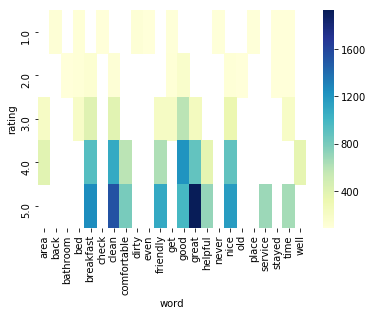

In [34]:
#Creating a heatmap
heat_map_data = short_df.pivot("rating",'word','count')
heat_map = sns.heatmap(heat_map_data, cmap="YlGnBu")

In [35]:
# Create a widget containing ratings (sorted alphabetically)
ratings = list(short_df.rating.unique())
ratings.sort()

rating_title = widgets.Dropdown(options = ["Choose a rating..."] + ratings, value = "Choose a rating...", 
                              description = "rating:", disabled = False)

In [36]:
# Create a filter based on title
def plot_it(rating_title):
    if rating_title != "Choose a rating...":
        df1 = short_df[short_df["rating"] == rating_title]
        
        plt.figure(figsize = (10, 6))
        sns.set(font_scale = 1.5)
        graph = sns.barplot(y = "word", x = "count", data = df1, palette = "YlGnBu")

In [37]:
# Plot the data by poem title
interactive(plot_it, rating_title = rating_title)

interactive(children=(Dropdown(description='rating:', options=('Choose a rating...', '1.0', '2.0', '3.0', '4.0…

## Word Clouds

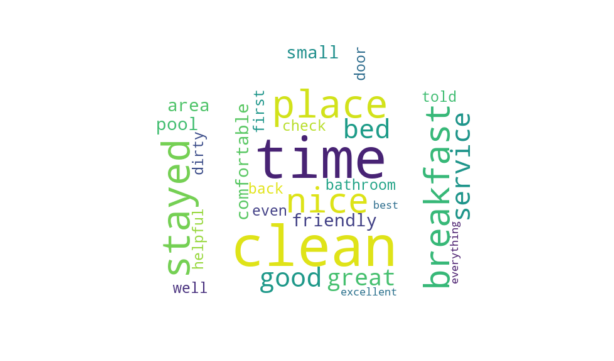

In [38]:
#world cloup preparation
wc_prep = df["word"].tolist()
wcloud_prep = ' '.join(wc_prep)
# read the mask image
case_mask = np.array(Image.open("images/case.jpg"))
# Make the figure
wordcloud = WordCloud(mask=case_mask, background_color="white", contour_color='steelblue', min_font_size=16).generate(wcloud_prep)
plt.figure(figsize = (15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud Rating 5.0

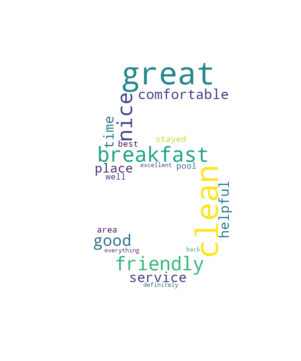

In [39]:
#world cloup preparation
wcloud_prep = ' '.join(word_list5)
# read the mask image
case_mask = np.array(Image.open("images/5.jpg"))
# Make the figure
wordcloud = WordCloud(mask=case_mask, background_color="white", contour_color='steelblue', min_font_size=16).generate(wcloud_prep)
plt.figure(figsize = (15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud Rating 4.0

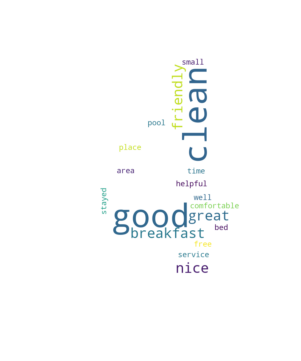

In [40]:
#world cloup preparation
wcloud_prep = ' '.join(word_list4)
# read the mask image
case_mask = np.array(Image.open("images/4.jpg"))
# Make the figure
wordcloud = WordCloud(mask=case_mask, background_color="white", contour_color='steelblue', min_font_size=16).generate(wcloud_prep)
plt.figure(figsize = (15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud Rating 3.0

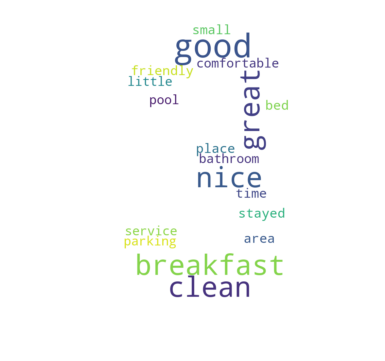

In [41]:
#world cloup preparation
wcloud_prep = ' '.join(word_list3)
# read the mask image
case_mask = np.array(Image.open("images/3.jpg"))
# Make the figure
wordcloud = WordCloud(mask=case_mask, background_color="white", contour_color='steelblue', min_font_size=16).generate(wcloud_prep)
plt.figure(figsize = (15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud Rating 2.0

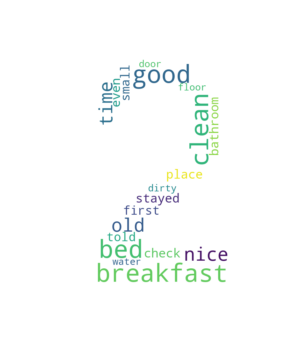

In [42]:
#world cloup preparation
wcloud_prep = ' '.join(word_list2)
# read the mask image
case_mask = np.array(Image.open("images/2.jpg"))
# Make the figure
wordcloud = WordCloud(mask=case_mask, background_color="white", contour_color='steelblue', min_font_size=16).generate(wcloud_prep)
plt.figure(figsize = (15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud Rating 1.0

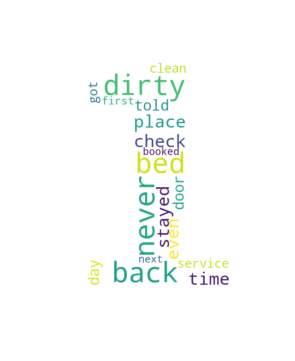

In [43]:
#world cloup preparation
wcloud_prep = ' '.join(word_list1)
# read the mask image
case_mask = np.array(Image.open("images/1.jpg"))
# Make the figure
wordcloud = WordCloud(mask=case_mask, background_color="white", contour_color='steelblue', min_font_size=16).generate(wcloud_prep)
plt.figure(figsize = (15, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()